In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:

# Define transformations (resize, normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

# Load dataset
dataset_path = r'C:\Users\Administrator\Desktop\EfficientNet\Augmented_Dataset_1000_1000'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Print class-to-index mapping
print("Class Index Mapping:", dataset.class_to_idx)


Class Index Mapping: {'1': 0, '10': 1, '100': 2, '1000': 3, '101': 4, '102': 5, '103': 6, '104': 7, '105': 8, '106': 9, '107': 10, '108': 11, '109': 12, '11': 13, '110': 14, '111': 15, '112': 16, '113': 17, '114': 18, '115': 19, '116': 20, '117': 21, '118': 22, '119': 23, '12': 24, '120': 25, '121': 26, '122': 27, '123': 28, '124': 29, '125': 30, '126': 31, '127': 32, '128': 33, '129': 34, '13': 35, '130': 36, '131': 37, '132': 38, '133': 39, '134': 40, '135': 41, '136': 42, '137': 43, '138': 44, '139': 45, '14': 46, '140': 47, '141': 48, '142': 49, '143': 50, '144': 51, '145': 52, '146': 53, '147': 54, '148': 55, '149': 56, '15': 57, '150': 58, '151': 59, '152': 60, '153': 61, '154': 62, '155': 63, '156': 64, '157': 65, '158': 66, '159': 67, '16': 68, '160': 69, '161': 70, '162': 71, '163': 72, '164': 73, '165': 74, '166': 75, '167': 76, '168': 77, '169': 78, '17': 79, '170': 80, '171': 81, '172': 82, '173': 83, '174': 84, '175': 85, '176': 86, '177': 87, '178': 88, '179': 89, '18': 9

In [4]:

# Split into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


In [5]:

# Define the model (ResNet-18)
class LightingRobustCNN(nn.Module):
    def __init__(self, num_classes):
        super(LightingRobustCNN, self).__init__()
        self.backbone = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

# Initialize model
num_classes = len(dataset.classes)
model = LightingRobustCNN(num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

Epoch [1/10], Loss: 0.2724
Epoch [2/10], Loss: 0.0132
Epoch [3/10], Loss: 0.0066
Epoch [4/10], Loss: 0.0044
Epoch [5/10], Loss: 0.0032
Epoch [6/10], Loss: 0.0024
Epoch [7/10], Loss: 0.0020
Epoch [8/10], Loss: 0.0015
Epoch [9/10], Loss: 0.0013
Epoch [10/10], Loss: 0.0012


In [26]:

# Evaluate the model
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

incorrect = total - correct  # Count incorrect predictions
print(f'Accuracy of the network on {total} test images: {100 * correct / total:.9f}%')
print(f"Incorrect Predictions: {incorrect}/{total}")



Accuracy of the network on 195200 test images: 99.995389344%
Incorrect Predictions: 9/195200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.6158917].


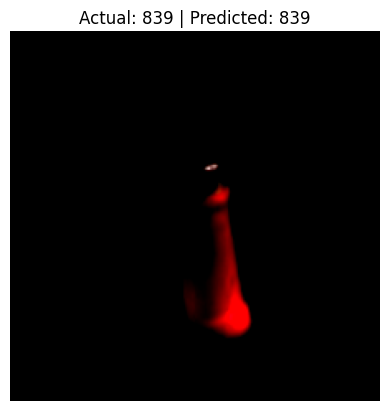

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.7938564].


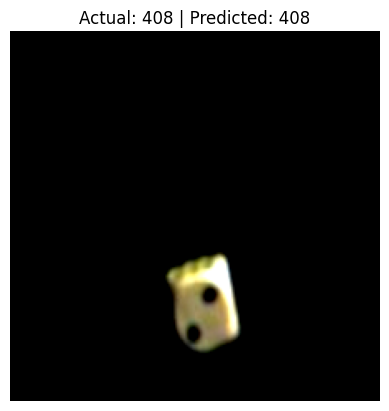

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.5388304].


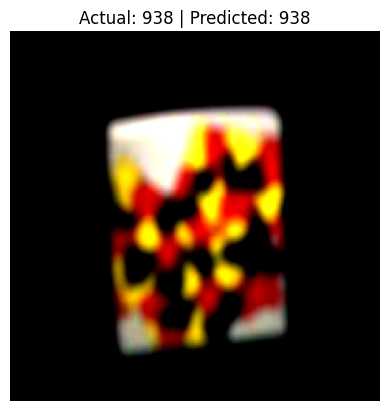

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55038965..0.2287867].


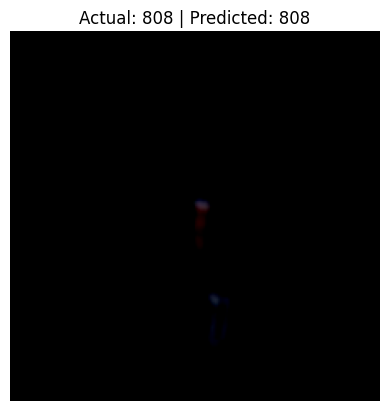

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.6158917].


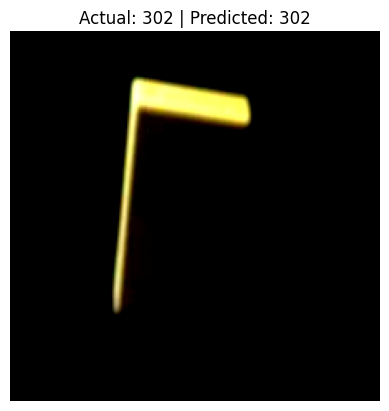

LightingRobustCNN(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [8]:

# Compare Actual vs. Predicted Labels on Test Data
def imshow(img, actual, predicted):
    img = img.cpu().numpy()  # Convert tensor to numpy
    img = img / 2 + 0.5  # Unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(f'Actual: {actual} | Predicted: {predicted}')
    plt.axis('off')
    plt.show()

# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Move to device
images, labels = images.to(device), labels.to(device)

# Get model predictions
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Convert indices to actual class names
actual_labels = [dataset.classes[i] for i in labels.cpu().numpy()]
predicted_labels = [dataset.classes[i] for i in predicted.cpu().numpy()]

# Show 5 test images with labels
for i in range(5):
    imshow(images[i], actual_labels[i], predicted_labels[i])

# Manually test with a single input image
model.eval()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


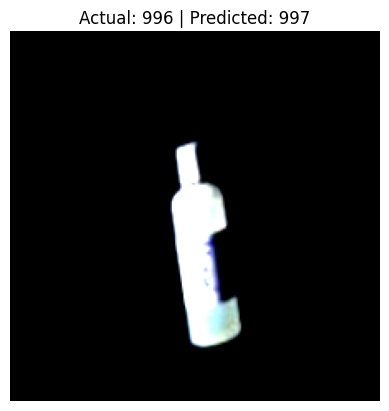

Actual: 996, Predicted: 997


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


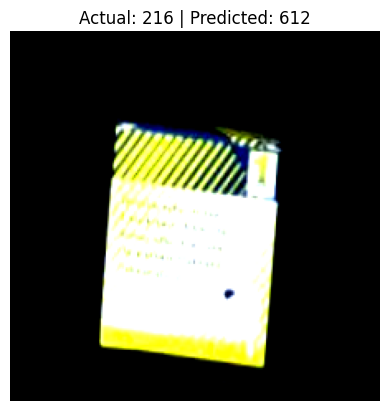

Actual: 216, Predicted: 612


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.6967788].


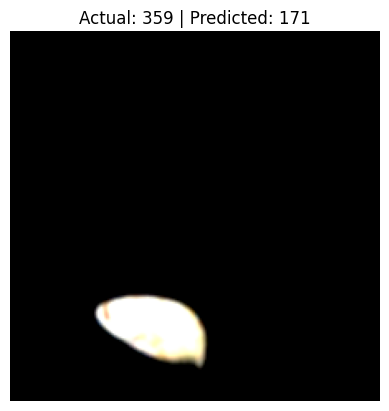

Actual: 359, Predicted: 171


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.5217056].


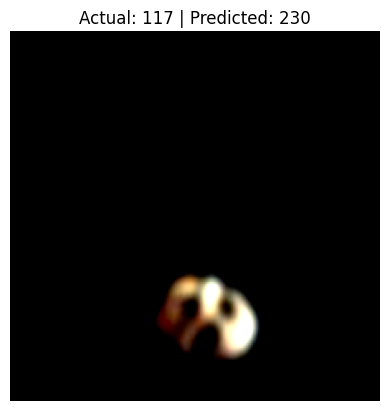

Actual: 117, Predicted: 230


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


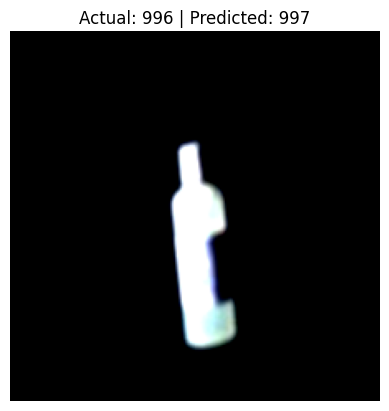

Actual: 996, Predicted: 997


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5332649..1.82].


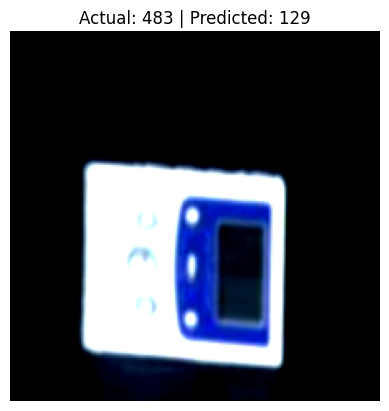

Actual: 483, Predicted: 129


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.6792717].


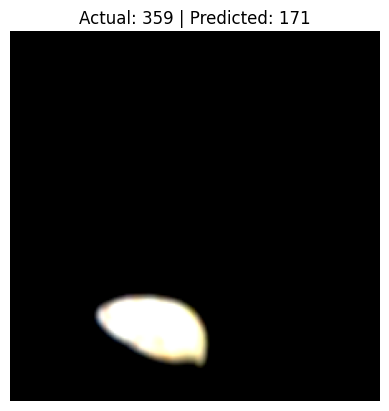

Actual: 359, Predicted: 171


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.6244541].


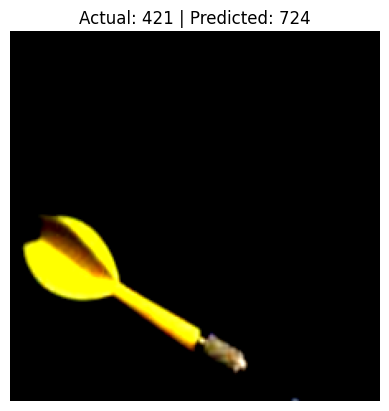

Actual: 421, Predicted: 724


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


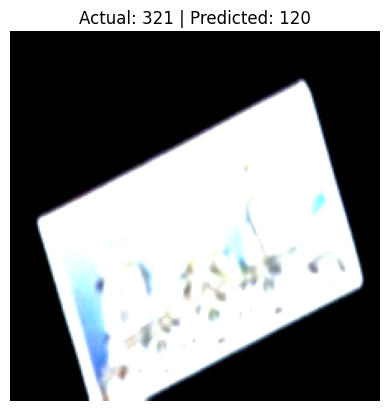

Actual: 321, Predicted: 120
Correct: 195191, Incorrect: 9


In [24]:
correct=0
incorrect=0
with torch.no_grad():
    for images, labels in test_loader:  # ✅ Use plural (because it's already a batch)
        for i in range(len(images)):  # ✅ Iterate over individual images
            image = images[i].unsqueeze(0).to(device)  # Add batch dim only for a single image
            label = labels[i]  # Get corresponding label
            
            output = model(image)
            _, predicted = torch.max(output, 1)
            if(label.item() != predicted.item()):
                imshow(image[0], dataset.classes[label.item()], dataset.classes[predicted.item()])
                print(f'Actual: {dataset.classes[label.item()]}, Predicted: {dataset.classes[predicted.item()]}')
                incorrect+=1
            else:
                correct+=1

print(f'Correct: {correct}, Incorrect: {incorrect}')
